# Civility in Communication

The focus of this assignment will be on a) training a classifier to perform hate speech detection; b) use LIME to explain the classifier's behaviour; c) establish whether the classifier might be biased wrt. different demographic dialects.

This assignment is divided into three parts:
1. **Before the laboratory** (individually): read [LIME's paper](https://arxiv.org/abs/1602.04938) and understand how its Python implementation works: https://github.com/marcotcr/lime (docs: https://lime-ml.readthedocs.io/en/latest/index.html). Check these tutorials in particular: [1](https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html) and [2](https://marcotcr.github.io/lime/tutorials/Lime%20-%20multiclass.html). Furthermore, download the dataset, read its description below and make sure you understand it. Finally, implement a classifier to detect offensive language (use the "label" column in the train and dev datasets). You could for example use a TF-IDF model with any classifier you like from sklearn. Your focus, before the laboratory, is to clearly understand LIME and the proposed dataset, as well as to bring your own classifier to the laboratory.
2. **During the laboratory** (in groups): compare your classifiers and chose one or two to work with (e.g., select the best-performing ones, or those using different methods). Split into two sub-groups: one will use LIME to come-up with explanations for classifications. In particular, they will focus on missclassifications and try to explain those. Another group will select a definition of bias (from literature - can be from week 2 or any other literature you find) and verify whether your classifier(s) are biased wrt. different demgraphic dialects. For this task, use your classifier(s) on the “mini_demographic_dev.tsv” dataset, and assess bias by demographic group (see below for details). At the end of the laboratory, try to combine your work by using LIME to explain biased classifications.
3. **After the laboratory** (in groups): wrap-up your work and write up your results and thoughts into a brief project report. Make sure to discuss the question of whether you think LIME is effective at explaining your classifier(s), whether you found bias in the classifier, and whether LIME explains biased classifications well (or not).

## Dataset

*This dataset and text is taken with permission from the [Computational Ethics for NLP course, HW2](http://demo.clab.cs.cmu.edu/ethical_nlp2020/homeworks/hw2/hw2.html).*

The primary data for this assignment is available in the dataset folder. **Please note that the data contains offensive or sensitive content, including profanity and racial slurs.**

We provide data drawn from two sources. The first (files "train.tsv" and "dev.tsv") consists of tweets annotated for offensiveness taken from the [2019 SemEval task](https://competitions.codalab.org/competitions/20011) on offensive language detection. In the files "train.tsv" and "dev.tsv", the first column (text) contains the text of a tweet, the second column (label) contains an offensiveness label:

* (NOT) Not Offensive - This post does not contain offense or profanity.
* (OFF) Offensive - This post contains offensive language or a targeted (veiled or direct) offense

The file “offenseval-annotation.txt” provides additional details on the annotation scheme.

We additionally provide a data set of tweets proxy-labelled for race in the file titled “mini_demographic_dev.tsv”. This data is taken from the [TwitterAAE](http://slanglab.cs.umass.edu/TwitterAAE/) data set and uses posterior proportions of demographic topics as a proxy for racial dialect ([details](https://www.aclweb.org/anthology/D16-1120.pdf)). The first column (“text”) contains the text of the tweet, and the second column (“demographic”) contains a label: “AA” (for “African American”), “White”, “Hispanic”, or “Other”. For this assignment, we assume that no tweet in the TwitterAAE data set contains toxic language. Thus, any tweet in this file that is classified as toxic is a false positive.

Finally, both development sets (“dev.tsv” and “mini_demographic_dev.tsv”) contain a column “perspective_score”, which contains a toxicity score. These scores were obtain using the [PerspectiveAPI tool](https://www.perspectiveapi.com/) released by Alphabet. This tool is intended to help “developers and publishers…give realtime feedback to commenters or help moderators do their job”

In all data sets, user mentions have been replaced with the token @USER.

In [10]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import nltk, sklearn

import random
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.proportion import proportion_confint

### Load and inspect the dataset

In [11]:
df_train = pd.read_csv("dataset/civility_data/train.tsv", sep="\t")
df_dev = pd.read_csv("dataset/civility_data/dev.tsv", sep="\t")
df_test = pd.read_csv("dataset/civility_data/test.tsv", sep="\t")
df_demo = pd.read_csv("dataset/civility_data/mini_demographic_dev.tsv", sep="\t")

In [12]:
print(df_train.shape)

(10592, 3)


In [13]:
df_train.head()

,text,label,category
0,@USER @USER You are an embarrassing citizen!!,OFF,TIN
1,@USER Seems hard to believe that you stood nex...,OFF,TIN
2,@USER @USER @USER Wow !!! no wonder the Libera...,OFF,TIN
3,@USER @USER And not all idiots grandstands lik...,OFF,TIN
4,@USER Bring on the hypocrite gungrabber. MAGA,OFF,TIN


In [14]:
df_demo.head()

,text,demographic,perspective_score
0,People make mistakes. It takes a good person t...,White,0.041031
1,"Only one on our road with power, but no cable ...",White,0.061435
2,I love when baby's yawn I think it's so cute.,White,0.056817
3,theres so many hoes now that i actually think ...,White,0.503459
4,Today is the day Adalynn Alexis will be here! ...,White,0.092183


## Train a classifier (Random Forest)

We train a text classification model using character-level (`analyzer='char_wb'`) TF-IDF features (with 4–6 character n-grams; `ngram_range=(4,6)`), removing very rare n-grams that appear in fewer than 5 documents (`min_df=5`). A Random Forest classifier is then fitted on the training data, used to predict labels for the dev set, and evaluated using precision, recall, and F1-score.

In [15]:
X_train = df_train['text']
y_train = df_train['label']

X_dev = df_dev['text']
y_dev = df_dev['label']

vectorizer = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(4,6),
    min_df=5,
    max_features=300000
)

X_train_t = vectorizer.fit_transform(X_train)
X_dev_t = vectorizer.transform(X_dev)

model = RandomForestClassifier(n_estimators=200, random_state=1)
model.fit(X_train_t, y_train)
y_pred = model.predict(X_dev_t)

print(classification_report(y_dev, y_pred))

              precision    recall  f1-score   support

         NOT       0.77      0.93      0.84       884
         OFF       0.76      0.44      0.55       440

    accuracy                           0.77      1324
   macro avg       0.76      0.68      0.70      1324
weighted avg       0.77      0.77      0.75      1324



## Explain with LIME

In [16]:
# Function to predict probabilities for LIME
def predict_proba_lime(texts):
    X = vectorizer.transform(texts)
    return model.predict_proba(X)

class_names = model.classes_
explainer = LimeTextExplainer(class_names=class_names)

# Select a random misclassified instance
# random_index = random.choice(np.where(y_dev != y_pred)[0])
# for the LIME explanation: 
random_index = 994

text_instance = X_dev.iloc[random_index]
print('Text to explain:\n', text_instance)

true_label = y_dev.iloc[random_index]
pred_label = y_pred[random_index]

print('\nRandom index: ', random_index)
print('True label:', true_label)
print('Predicted label:', pred_label)

# Generate LIME explanation
exp = explainer.explain_instance(
    text_instance,
    predict_proba_lime,
    num_features=10
)

# Display the explanation, which includes words and their weights
print('\nLIME explanation:')
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.3f}")

Text to explain:
 *a shooting happens in a country with gun control laws for the first time in literally decades*  Y'all: BUT THE GUN LAWS SHOULD'VE PREVENTED THIS UNGA BUNGA THIS IS WHY GUN CONTROL SUCKS BET YOU DUMMIES WISH YOU HAD GUNS  *meanwhile another school shooting happens in America*

Random index:  994
True label: NOT
Predicted label: OFF

LIME explanation:
SUCKS: 0.295
happens: -0.049
shooting: -0.046
PREVENTED: 0.045
SHOULD: -0.018
CONTROL: -0.016
control: -0.016
country: 0.011
a: 0.009
decades: 0.008


After applying LIME to the misclassifications, we can see how the different words contribute to the misclassification. The example above shows the text which is misclassified as offensive where the true label is actually not offensive. The Lime explanation shows that word 'SUCKS' is more related to a offensive prediction, because of its positive weight. In particular, the word SUCKS is likely associated with negative contexts in the training data, which causes the model to predict offensive. At the same time, other words such as 'shooting' receive a negative weight and therefore slightly push the prediction toward the not offensive class, but this effect is probably much smaller. So in this case, the model chooses to predict offensive, based on the negative word 'SUCKS'.

Best word: sucks
Removed feature: "sucks"
Removed feature: " sucks"
Removed feature: "sucks "

Original prediction:
  class = OFF, probability = 0.5800

Prediction removing best word:
  class = NOT, probability = 0.4800

Difference in probability: -0.09999999999999998


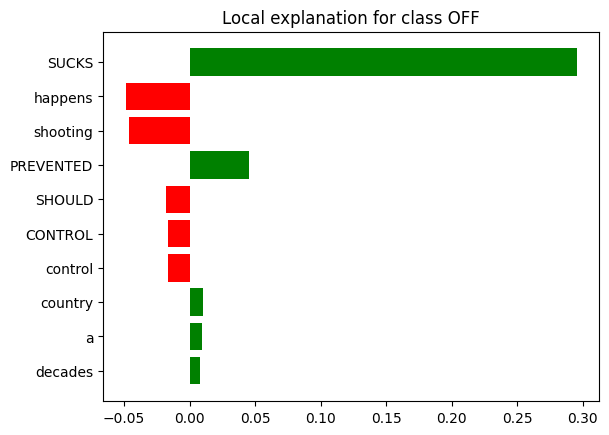

In [17]:
# ---- Remove the most important feature ----

# Get the feature weights from LIME explanation
feature_weights = exp.as_list()
feature_weights = sorted(feature_weights, key=lambda x: abs(x[1]), reverse=True)

# Identify the best word (most impactful feature)
best_word = feature_weights[0][0].lower()
print(f"Best word: {best_word}")

tmp = vectorizer.transform([text_instance]).copy()

# Consider different spacing variants of the best word
variants = [
    best_word,
    f" {best_word}",
    f"{best_word} "
]

# Remove the best word from the feature vector
for v in variants:
    if v in vectorizer.vocabulary_:
        print(f'Removed feature: "{v}"')
        tmp[0, vectorizer.vocabulary_[v]] = 0

# ---- Predictions ----
orig_vec = vectorizer.transform([text_instance])

orig_proba = model.predict_proba(orig_vec)[0, 1]
new_proba = model.predict_proba(tmp)[0, 1]

orig_pred = model.predict(orig_vec)[0]
new_pred = model.predict(tmp)[0]

# Print the probabilities of the original and modified instances
print('\nOriginal prediction:')
print(f'  class = {orig_pred}, probability = {orig_proba:.4f}\n')
print('Prediction removing best word:')
print(f'  class = {new_pred}, probability = {new_proba:.4f}\n')
print('Difference in probability:', new_proba - orig_proba)

# Visualize the LIME explanation
fig = exp.as_pyplot_figure()
plt.show()

After we got the LIME explanation, we tried to remove the word with the highest weight according to LIME. Then we predict the text again and we observe a clear drop in the predicted probability for the offensive class, and in this case even a change in the predicted label from offensive to not offensive. This also suggest that the word 'SUCKS' plays a strong local role in the model’s decision for this particular example.

## A biased classifier?
We want to check whether our logistic regression classifier shows **demographic bias**
when predicting "OFF" (offensive) on a dataset with various tweets with different **demographic dialects** in which **all tweets are labeled as "NOT" (not offensive)**.

In other words: we are looking at **false positive rate (FPR)** across different demographics.

High difference in FPR between groups may indicate demographic bias.

#### Classifier (Logistic regression)

In [18]:
df_demo = df_demo.reset_index(drop=True)

# All true labels in this set are 'NOT'
X_dev = df_demo['text']
y_dev = ['NOT'] * len(df_demo)

X_dev_t = vectorizer.transform(X_dev)

# Model, class_weight = balanced helps when data is imbalanced
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced', 
    random_state=201
)
# Fit model and predict on the data to get the predicted labels
model.fit(X_train_t, y_train)
y_pred = model.predict(X_dev_t)
print(classification_report(y_dev, y_pred))

# The predicted labels to which we will compare the true labels (all "NOT")
df_demo["pred_label"] = y_pred

              precision    recall  f1-score   support

         NOT       1.00      0.76      0.86      5072
         OFF       0.00      0.00      0.00         0

    accuracy                           0.76      5072
   macro avg       0.50      0.38      0.43      5072
weighted avg       1.00      0.76      0.86      5072



/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

#### Verify if the classifier is biased

In [19]:
# Quick distribution check of the counts between all demographics to see difference in counts between groups
print("Distribution by counts")
print(df_demo['demographic'].value_counts())
print()
print("Distribution by percentages")
print((df_demo['demographic'].value_counts(normalize=True) * 100).round(2))

Distribution by counts
demographic
White       4235
Hispanic     335
AA           332
Other        170
Name: count, dtype: int64

Distribution by percentages
demographic
White       83.50
Hispanic     6.60
AA           6.55
Other        3.35
Name: proportion, dtype: float64


In [24]:
print("False positives (FP) by demographic:")
for group in df_demo['demographic'].unique():
    # Select rows belonging to current demographic group and get the # of rows
    n = len(df_demo[df_demo['demographic'] == group])
    
    # How many times did we predict OFF? (these are all false positives!)
    fp = (df_demo[df_demo['demographic'] == group]['pred_label'] == 'OFF').sum()
    
    ci_low, ci_high = proportion_confint(count=fp, nobs=n, alpha=0.05, method='wilson')

    print(f"{group:8}: Count = {n:4} | FP = {fp:3} | FPR {fp/n:.2%} | [{ci_low:.2%}, {ci_high:.2%}]")


False positives (FP) by demographic:
White   : Count = 4235 | FP = 1019 | FPR 24.06% | [22.80%, 25.37%]
Hispanic: Count =  335 | FP =  98 | FPR 29.25% | [24.64%, 34.34%]
AA      : Count =  332 | FP = 115 | FPR 34.64% | [29.72%, 39.91%]
Other   : Count =  170 | FP =   6 | FPR 3.53% | [1.63%, 7.49%]


### Interpretation of results
- **FPR** = False Positive Rate = % of non-offensive texts that were wrongly classified as offensive
- In an ideal world. FPR should be **similar** across all demographic groups
- Big differences (especially >5–10 percentage points) usually indicate bias

The results indicate that the model shows large variation in FPR between different demographic dialects. Tweets associated with African American (AA) dialects show the highest false positive rate with being seen ~1,44x more probable as offensive compared to a White dialect and ~1,18x to a Hispanic dialect

The 95% confidence intervals also show no overlap between AA and White dialects thus reinforcing the fact that there might be strong bias in our classifier. Hispanic dialects also seem to have a higher probability to be seen as offensive compared to a white dialect, but the difference is smaller than a AA dialect. When we also take a look at the confidence intervals we do see small overlap with a white dialect indicating that the bias between White and Hispanic dialects are smaller than that of a AA dialect.


#### Explain with LIME

Text to explain:
 Turn off: talkin too nasty \ yuh gone eat dis ass\ no no no nasty bitch #skincrawlin

Random index:  4043
True label: NOT
Predicted label: OFF

LIME explanation:
bitch: 0.223
nasty: 0.056
ass: 0.038
gone: -0.032
talkin: 0.032
eat: 0.021
skincrawlin: -0.016
dis: 0.012
off: 0.012
too: -0.010


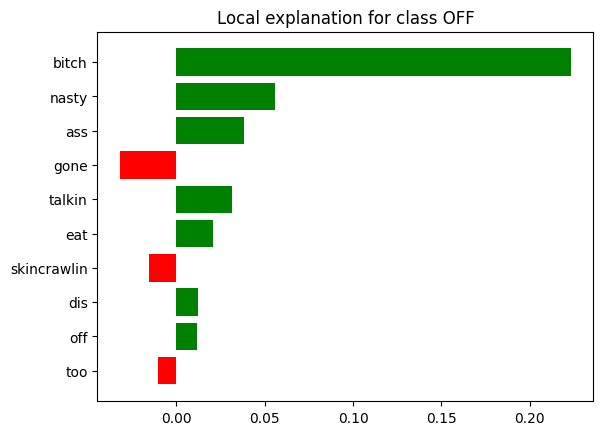

In [21]:
aa_fp = df_demo[
    (df_demo['demographic'] == 'AA') &
    (df_demo['pred_label'] == 'OFF')
]

random_row = aa_fp.sample(n=1, random_state=None)
random_index = random_row.index[0]

text_instance = X_dev.iloc[random_index]
print('Text to explain:\n', text_instance)

true_label = "NOT"
pred_label = y_pred[random_index]

print('\nRandom index: ', random_index)
print('True label:', true_label)
print('Predicted label:', pred_label)

exp = explainer.explain_instance(
    text_instance,
    predict_proba_lime,
    num_features=10
)

print('\nLIME explanation:')
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.3f}")
    
fig = exp.as_pyplot_figure()
plt.show()
